In [1]:
!pip install tf_agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 45.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 98.9 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697640 sha256=29d8ceadf0d318563be42391c30231b6dfaddc4946e415fd6eb489faad69cd9e
  Stored in directory: /root/.cache/pip/wheels/3d/6f/b4/3991d4fae11d0ecb0754c11cc1b4e7745012850da4efaaf0b1
Successfully built gym
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.20.0
    Uninstalling tensorflow-probability-0.20.0:
      Succes

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tempfile
import gin
import tensorflow_probability as tfp
from tf_agents.agents import data_converter
from tf_agents.agents import tf_agent
from tf_agents.distributions import utils as distribution_utils
from tf_agents.networks import network
from tf_agents.policies import actor_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import greedy_policy
from tf_agents.policies import q_policy
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types
from tf_agents.utils import common
import typing_extensions
import tensorflow as tf
from tf_agents.networks import actor_distribution_network
from tf_agents.environments import suite_gym
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
import collections
from typing import Optional, Callable , Text
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.environments import tf_py_environment
import tf_agents
from tf_agents.metrics import tf_metrics
from tf_agents.trajectories import trajectory
from tf_agents.policies import random_tf_policy
from tf_agents.environments.tf_py_environment import TFPyEnvironment
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_network import QNetwork
from tf_agents.policies.random_tf_policy import RandomTFPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils.common import function

In [2]:
Literal = typing_extensions.Literal


class BehavioralCloningLossInfo(collections.namedtuple(
    'BehavioralCloningLossInfo', ('loss'))):
  pass


@gin.configurable
class BehavioralCloningAgent(tf_agent.TFAgent):
  

  def __init__(
      self,
      time_step_spec: ts.TimeStep,
      action_spec: types.NestedTensorSpec,
      cloning_network: network.Network,
      optimizer: types.Optimizer,
      num_outer_dims: Literal[1, 2] = 2,  # pylint: disable=bad-whitespace
      epsilon_greedy: types.Float = 0.1,
      loss_fn: Optional[Callable[[types.NestedTensor, bool],
                                 types.Tensor]] = None,
      gradient_clipping: Optional[types.Float] = None,
      # Params for debugging.
      debug_summaries: bool = False,
      summarize_grads_and_vars: bool = False,
      train_step_counter: Optional[tf.Variable] = None,
      name: Optional[Text] = None):
    
    tf.Module.__init__(self, name=name)
    self._cloning_network = cloning_network
    self._optimizer = optimizer
    self._gradient_clipping = gradient_clipping

    action_spec = tensor_spec.from_spec(action_spec)
    flat_action_spec = tf.nest.flatten(action_spec)
    continuous_specs = [tensor_spec.is_continuous(s) for s in flat_action_spec]

    if not flat_action_spec:
      raise ValueError('The `action_spec` must contain at least one action.')

    single_discrete_scalar_action = (
        len(flat_action_spec) == 1 and
        flat_action_spec[0].shape.rank == 0 and
        not tensor_spec.is_continuous(flat_action_spec[0]))
    single_continuous_action = (
        len(flat_action_spec) == 1 and
        tensor_spec.is_continuous(flat_action_spec[0]))

    if (not loss_fn and not single_discrete_scalar_action and
        not single_continuous_action):
      raise ValueError(
          'A `loss_fn` must be provided unless there is a single, scalar '
          'discrete action or a single (scalar or non-scalar) continuous '
          'action.')

    self._network_output_spec = cloning_network.create_variables(
        time_step_spec.observation)

    # If there is a mix of continuous and discrete actions we want to use an
    # actor policy so we can use the `setup_as_continuous` method as long as the
    # user provided a custom loss_fn which we verified above.
    if any(continuous_specs):
      policy, collect_policy = self._setup_as_continuous(
          time_step_spec, action_spec, loss_fn)
    else:
      policy, collect_policy = self._setup_as_discrete(time_step_spec,
                                                       action_spec, loss_fn,
                                                       epsilon_greedy)

    super(BehavioralCloningAgent, self).__init__(
        time_step_spec,
        action_spec,
        policy,
        collect_policy,
        train_sequence_length=None,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        train_step_counter=train_step_counter)

    self._as_trajectory = data_converter.AsTrajectory(
        self.data_context, sequence_length=None,
        num_outer_dims=num_outer_dims)

  @property
  def cloning_network(self):
    return self._cloning_network

  def _discrete_loss(self, experience, training=False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])

    network_state = self._cloning_network.get_initial_state(batch_size)
    action, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    # Get logits if the output of the cloning network is a distribution.
    if isinstance(action, tfp.distributions.Distribution):
      bc_logits = action.logits_parameter()
    else:
      bc_logits = action

    def loss(action, bc_logits, spec):
      # Subtract the minimum so that we get a proper cross entropy loss on
      # [0, maximum - minimum).
      return tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=action - spec.minimum, logits=bc_logits)

    losses = tf.nest.map_structure(loss, experience.action, bc_logits,
                                   self.action_spec)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _continuous_loss_fn(self, experience, training: bool = False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])
    network_state = self._cloning_network.get_initial_state(batch_size)
    bc_output, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    if isinstance(bc_output, tfp.distributions.Distribution):
      bc_action = bc_output.sample()
    else:
      bc_action = bc_output

    losses = tf.nest.map_structure(tf.losses.mse, experience.action, bc_action)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _setup_as_discrete(self, time_step_spec, action_spec, loss_fn,
                         epsilon_greedy):
    self._bc_loss_fn = loss_fn or self._discrete_loss

    if any(isinstance(d, distribution_utils.DistributionSpecV2) for
           d in tf.nest.flatten([self._network_output_spec])):
      # If the output of the cloning network contains a distribution.
      base_policy = actor_policy.ActorPolicy(time_step_spec, action_spec,
                                             self._cloning_network)
    else:
      # If the output of the cloning network is logits.
      base_policy = q_policy.QPolicy(
          time_step_spec,
          action_spec,
          q_network=self._cloning_network,
          validate_action_spec_and_network=False)
    policy = greedy_policy.GreedyPolicy(base_policy)
    collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
        base_policy, epsilon=epsilon_greedy)
    return policy, collect_policy

  def _setup_as_continuous(self, time_step_spec, action_spec, loss_fn):
    self._bc_loss_fn = loss_fn or self._continuous_loss_fn
    collect_policy = actor_policy.ActorPolicy(
        time_step_spec, action_spec, actor_network=self._cloning_network)
    policy = greedy_policy.GreedyPolicy(collect_policy)
    return policy, collect_policy

  def _loss(self, experience, weights=None, training: bool = False):
    experience = self._as_trajectory(experience)

    per_example_loss = self._bc_loss_fn(experience, training=training)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup
    aggregated_losses = common.aggregate_losses(
        per_example_loss=per_example_loss,
        sample_weight=weights,
        regularization_loss=self._cloning_network.losses)

    return tf_agent.LossInfo(
        loss=aggregated_losses.total_loss,
        extra=BehavioralCloningLossInfo(per_example_loss))

  def _train(self, experience, weights=None):
    experience = self._as_trajectory(experience)

    with tf.GradientTape() as tape:
      per_example_loss = self._bc_loss_fn(experience, training=True)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup

      aggregated_losses = common.aggregate_losses(
          per_example_loss=per_example_loss,
          sample_weight=weights,
          regularization_loss=self._cloning_network.losses)

    self._apply_loss(aggregated_losses,
                     variables_to_train=self._cloning_network.trainable_weights,
                     tape=tape,
                     optimizer=self._optimizer)

    self.train_step_counter.assign_add(1)
    return tf_agent.LossInfo(aggregated_losses.total_loss,
                             BehavioralCloningLossInfo(per_example_loss))

## LOAD THE EXPERIENCE REPLAY BUFFER WITH EXPERIENCES COLLECTED BY A DQN AGENT

In [3]:
# Create the environment.
env_name = "CartPole-v0"
env = suite_gym.load(env_name)
tf_env = TFPyEnvironment(env)

In [4]:
# Create the Q-Network.
fc_layer_params = (100,)
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [5]:
# Define the optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-3)

In [16]:
# Initialize the DQN Agent.
train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_huber_loss,
    train_step_counter=train_step_counter)

# Initialize the agent.
agent.initialize()

In [15]:
# Create the replay buffer.
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000)

In [8]:
# Create the metric.
average_return = tf_metrics.AverageReturnMetric(buffer_size=100)  # Compute the average return over the last 100 episodes.

# Create the observer.
observers = [replay_buffer.add_batch, average_return]

In [ ]:
num_episodes = 100
# Collect experience.
#initial_collect_steps = 10000
initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())
initial_driver = DynamicEpisodeDriver(
    tf_env,
    agent.collect_policy,
    observers=observers,
    num_episodes=num_episodes)  # Collect 1,0000 episodes.
# Collect the data.
returns = []
for i in range(num_episodes):
    initial_time_step = tf_env.reset()
    initial_driver.run(initial_time_step)
    returns.append(average_return.result())
    if i % 200 == 0:
        print('Iteration:', i, 'Reward:', average_return.result().numpy())

Iteration: 0 Reward: tf.Tensor(9.93, shape=(), dtype=float32)


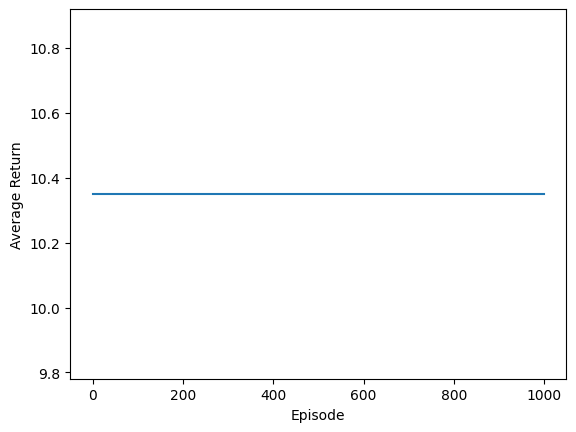

In [11]:
# Plot the average return.
returns = [average_return.result().numpy() for _ in range(num_episodes)]
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.show()

In [12]:
# Train the agent.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)

agent.train = function(agent.train)
train_loss_list = []
for i in range(20000):
    experience, _ = next(iterator)
    train_loss = agent.train(experience)
    # Append the current loss value to the list
    train_loss_list.append(train_loss.loss)

    # Print the current iteration number and the training loss every 100 iterations
    if i % 200 == 0:
        print('Iteration:', i, 'Training loss:', train_loss.loss.numpy())

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Iteration: 0 Training loss: 0.4593997
Iteration: 200 Training loss: 7.8912067
Iteration: 400 Training loss: 22.262194
Iteration: 600 Training loss: 56.284866
Iteration: 800 Training loss: 125.12857
Iteration: 1000 Training loss: 196.64748
Iteration: 1200 Training loss: 270.76447
Iteration: 1400 Training loss: 441.45767
Iteration: 1600 Training loss: 502.47455
Iteration: 1800 Training loss: 514.2014
Iteration: 2000 Training loss: 674.94214
Iteration: 2200 Training loss: 1087.4391
Iteration: 2400 Training loss: 1346.088
Iteration: 2600 Training loss: 1042.8994
Iteration: 2800 Training loss: 1262.2936
Iteration: 3000 Training loss: 1580.9014
Iteration: 3200 Training loss: 2988.7856
Iteration: 3400 Training loss: 2058.144
Iteration: 3600 Training loss: 2327.1067
Iteration: 3800 Training loss: 2243.3594
Iteration: 4000 Training loss: 2924.4526
Iteration: 4200 Training loss: 2951.351
Iteration: 4400 Training loss: 3884.751
Iteration: 4600 Training loss: 3009.6387
Iteration: 4800 Training los

## NOW THAT THE DQN AGENT HAS A BETTER POLICY TO INTERACT WITH THE ENVIRONMENT, LETS COLLECT SOME MORE EXPERIENCES AND STORE IT IN A NEW REPLAY BUFFER. THIS IS THE SET OF EXPERIENECS THAT THE BEHAVIORAL CLONING AGENT WILL LEARN FROM.

In [14]:
#num_episodes=1000
# Create another replay buffer.
training_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=10000)

# Create a new driver that uses the agent's policy to interact with the environment.
new_driver = DynamicEpisodeDriver(
    tf_env,
    agent.collect_policy,
    observers=observers,
    num_episodes=num_episodes)  # Collect 10,000 episodes.

# Collect the data.
initial_time_step = tf_env.reset()
new_driver.run(initial_time_step)

KeyboardInterrupt: ignored

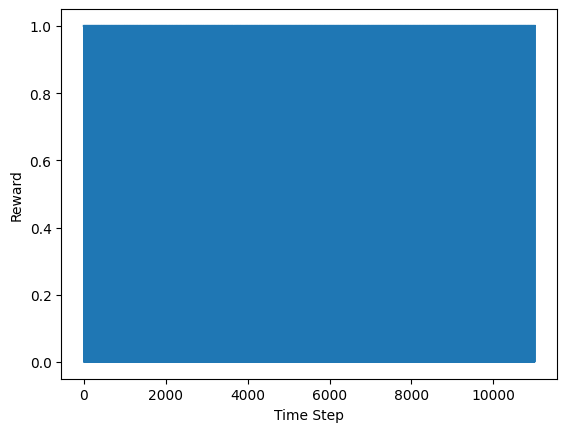

In [12]:
# Plot the average return.
returns = [average_return.result().numpy() for _ in range(num_episodes)]
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.show()

## INITIALIZE BEHAVIORAL CLONING AGENT

In [13]:
observation_spec = tf_env.observation_spec()
action_spec = tf_env.action_spec()

In [14]:
# Initialize the Actor Distribution Network
actor_net = actor_distribution_network.ActorDistributionNetwork(
    observation_spec,
    action_spec,
    fc_layer_params=(100,))

In [15]:
# Initialize the Behavioral Cloning Agent
train_step_counter = tf.Variable(0)
agent_b = BehavioralCloningAgent(
    time_step_spec=ts.time_step_spec(observation_spec),
    action_spec=action_spec,
    cloning_network=actor_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter)

In [16]:
# Convert the replay buffer to a TensorFlow dataset
experience_dataset = training_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=1).prefetch(3)

In [17]:
experience_dataset_iterator = iter(experience_dataset)

In [18]:
# Make the Behavioral Cloning Agent's train function a TensorFlow graph function
agent_b.train = common.function(agent_b.train)

In [21]:
# Run the training loop
num_iterations = 50000  # adjust this to your needs
# Create a list to store the loss values
train_loss_list = []
for i in range(num_iterations):
    # Sample a batch of experiences from the replay buffer
    trajectories, _ = next(experience_dataset_iterator)
    
    # Train the agent on the sampled experiences
    train_loss = agent_b.train(trajectories)
    
    # Append the current loss value to the list
    train_loss_list.append(train_loss.loss)
    
    # Print the current iteration number and the training loss every 100 iterations
    if i % 200 == 0:
        print('Iteration:', i, 'Training loss:', train_loss.loss.numpy())

Iteration: 0 Training loss: 0.14094016
Iteration: 200 Training loss: 0.09786249
Iteration: 400 Training loss: 0.14457163
Iteration: 600 Training loss: 0.22923437
Iteration: 800 Training loss: 0.184559
Iteration: 1000 Training loss: 0.18796508
Iteration: 1200 Training loss: 0.24120346
Iteration: 1400 Training loss: 0.09568128
Iteration: 1600 Training loss: 0.09799052
Iteration: 1800 Training loss: 0.30332533
Iteration: 2000 Training loss: 0.2902959
Iteration: 2200 Training loss: 0.13998863
Iteration: 2400 Training loss: 0.19005542
Iteration: 2600 Training loss: 0.2348811
Iteration: 2800 Training loss: 0.23225042
Iteration: 3000 Training loss: 0.23646031
Iteration: 3200 Training loss: 0.15437475
Iteration: 3400 Training loss: 0.2750783
Iteration: 3600 Training loss: 0.054970037
Iteration: 3800 Training loss: 0.23832884
Iteration: 4000 Training loss: 0.32194415
Iteration: 4200 Training loss: 0.18631108
Iteration: 4400 Training loss: 0.14370355
Iteration: 4600 Training loss: 0.23054573
Ite

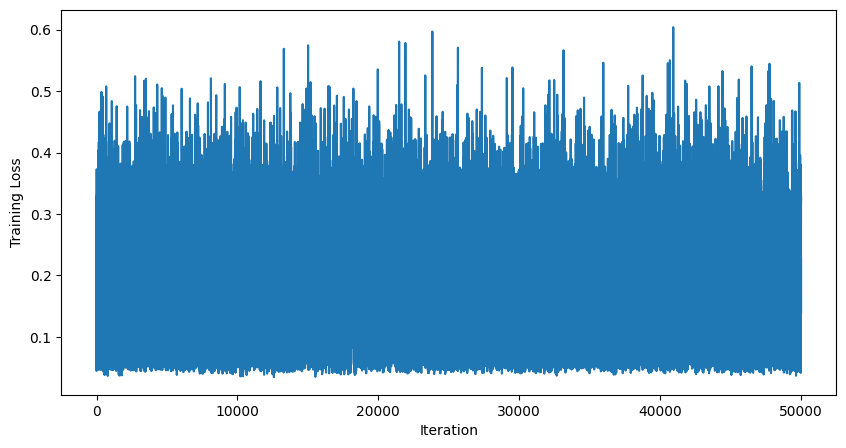

In [22]:
# TRY INTERVAL PLOT
# After the training loop, plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(train_loss_list)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()

## LET'S FIND OUT IF OUT BEHAVIORAL CLONING AGENT INTERACTS WITH CARTPOLE BETTER AFTER TRAINING ON THE REPLAY BUFFER FULL OF EEXPERIENCES

In [23]:
# Create another replay buffer.
training_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=10000)

# Create list to hold rewards
BC_rewards = []

def record_rewards(trajectory):
    BC_rewards.append(trajectory.reward)

# Create a new driver that uses the agent's policy to interact with the environment.
new_driver = DynamicStepDriver(
    tf_env,
    agent_b.collect_policy,
    observers=[training_replay_buffer.add_batch, record_rewards],
    num_steps=10000)  # Collect 10,000 steps.

# Reset the environment and run the new driver.
new_initial_time_step = tf_env.reset()
new_driver.run(new_initial_time_step)

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[ 0.03014286,  1.3352253 , -0.14455193, -2.1831336 ]],
       dtype=float32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}),
 ())

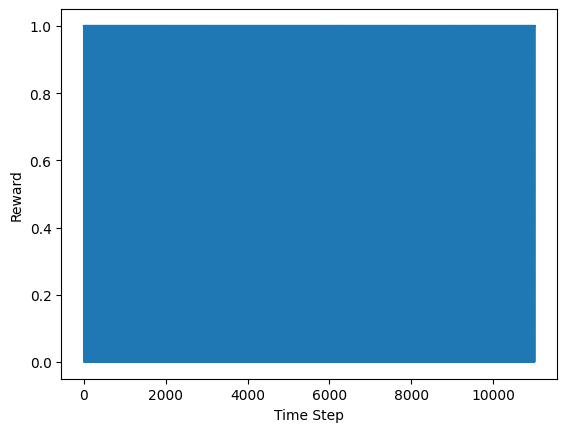

In [24]:
# Convert list of tensors to numpy array
BC_rewards_array = np.array([r.numpy() for r in BC_rewards])

# Plot rewards
plt.plot(BC_rewards_array)
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.show()